In [67]:
import os
import copy
import torch
import open_clip
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import pickle as pkl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from datasets import CUBDataset, get_transforms, DEFAULT_ATTR_INDICES

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# transforms = get_transforms()
dataset = CUBDataset(os.path.join('datasets', 'CUB'), split='train', transforms=None)

In [120]:
img_id, img, class_id, attrs = dataset[31]

In [121]:
img_id

tensor(9561)

In [122]:
class_id

tensor(162)

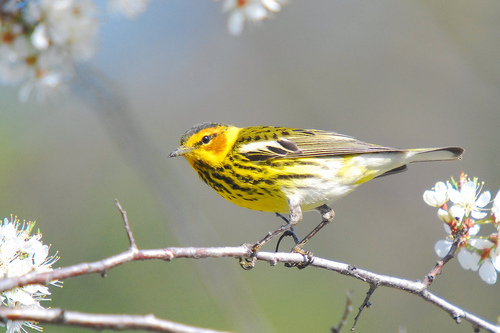

In [123]:
img

In [124]:
attrs

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [133]:
def get_instance_attr_names(img_id: torch.Tensor, attrs: torch.Tensor) -> pd.DataFrame:
    img_id, attrs = img_id.item(), attrs.bool().numpy()
    instance_attr_labels = dataset.attr_df.loc[img_id, 'attribute_id']
    original_attr_idxs = instance_attr_labels.loc[attrs].to_numpy()
    df[original_attr_idxs]

array([  6,  15,  20,  29,  30,  35,  45,  50,  56,  64,  69,  75, 111,
       116, 145, 151, 157, 203, 208, 218, 235, 238, 254, 259, 274, 277,
       298, 310])

In [125]:
default_attr_idxs = dataset.attr_df.loc[img_id, 'attribute_id']
attributes = pd.read_csv('datasets/CUB/attributes.txt', sep=' ', names=['attr_id', 'attr_name']).drop(columns=['attr_id'])
attributes.iloc[default_attr_idxs[attrs.bool()]]

,attr_name
6,has_bill_shape::all-purpose
15,has_wing_color::yellow
20,has_wing_color::black
29,has_upperparts_color::grey
30,has_upperparts_color::yellow
35,has_upperparts_color::black
45,has_underparts_color::yellow
50,has_underparts_color::black
56,has_breast_pattern::striped
64,has_back_color::yellow


In [106]:
attributes

,attr_name
0,has_bill_shape::curved_(up_or_down)
1,has_bill_shape::dagger
2,has_bill_shape::hooked
3,has_bill_shape::needle
4,has_bill_shape::hooked_seabird
...,...
307,has_crown_color::buff
308,has_wing_pattern::solid
309,has_wing_pattern::spotted
310,has_wing_pattern::striped


In [100]:
attributes.iloc[default_attr_idxs]

,attr_name
1,has_bill_shape::dagger
4,has_bill_shape::hooked_seabird
6,has_bill_shape::all-purpose
7,has_bill_shape::cone
10,has_wing_color::brown
...,...
305,has_crown_color::white
308,has_wing_pattern::solid
309,has_wing_pattern::spotted
310,has_wing_pattern::striped


In [109]:
a = dataset.attr_df.loc[3026]
a[a['attribute_id'] == 126]

,attribute_id,is_present,certainty_id,class_id,is_present_calibrated
image_id,,,,,
3026,126,0,3,52,0.25


In [60]:
a = next(loader_iter)
a

[tensor([ 5440,  1382,  1841,   517,  3131, 10621,  7377, 11492,  5173,  2041,
          9720,  2707, 11420,  7098,  8159,  9027]),
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1619, 0.1603, 0.1573],
           [0.0000, 0.0000, 0.0000,  ..., 0.1571, 0.1571, 0.1577],
           [0.0000, 0.0000, 0.0000,  ..., 0.1571, 0.1577, 0.1604],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.8319, 0.8319, 0.8152],
           [0.0000, 0.0000, 0.0000,  ..., 0.8442, 0.8419, 0.8224],
           [0.0000, 0.0000, 0.0000,  ..., 0.8027, 0.8045, 0.8567]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.2078, 0.2067, 0.2084],
           [0.0000, 0.0000, 0.0000,  ..., 0.2082, 0.2082, 0.2087],
           [0.0000, 0.0000, 0.0000,  ..., 0.2055, 0.2060, 0.2087],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.8115, 0.8115, 0.7766],
           [0.0000, 0.0000, 0.0000,  ..., 0.8341, 0.8287, 0.7677],
           [0.0000, 0.0000, 0.0000,  ..., 0.8000, 0.7998, 0.8410]],
 
          [[0.0000, 0.0000